<a href="https://colab.research.google.com/github/asdjimespoir/Skin_Lesion_Segmentation_Cancer_Detection/blob/main/Cancer_Detection_with_EfficientNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Le projet est principalement divisé en deux parties :

TensorFlow et Keras sont utilisés pour construire et créer un modèle d'apprentissage automatique.
TFLite est utilisé pour déployer le modèle sur une application Android.
Tensorflow avec le modèle Keras Deep Learning

À l'aide de réseaux de neurones convolutifs, nous avons développé des algorithmes et des modèles pour faire la distinction entre les cancers de la peau bénins et malins. Pour l'édition du code source, nous utilisons Colab.

Code source pour le modèle CNN de formation

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

Chargement des données :

Chargez le jeu de données. Pour cela, vous pouvez utiliser votre propre jeu de données personnalisé. Dans ce blog, nous allons utiliser la classification binaire de l'ensemble de données sur le cancer de la peau bénin vs malin. Après cela, nous devons étiqueter.

In [ ]:
from google.colab import drive
drive.mount('/content/Dataset')

Mounted at /content/Dataset


In [ ]:
train_dir='/content/Dataset/MyDrive/DL/Dataset/'
Labels = ['Benign', 'Malignant']
print ("Class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i])

Class : 
0 Benign
1 Malignant


In [ ]:
print('Number of classes:',len(Labels))

Number of classes: 2


Transfert d'apprentissage avec le hub TensorFlow :

Sélectionnez le module Hub/TF2 à utiliser, vous avez le choix entre inception v3 ou Mobilenet. Dans le blog, nous utilisons le modèle MobileNet.

In [ ]:
module_selection = ("efficientnet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}_imagenet1k_b0/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

Prétraitement des données :

Configurez des générateurs de données pour lire les images de nos dossiers source, les transformer en tenseurs float32 et les transmettre à notre réseau (avec leurs étiquettes). Comme vous le savez peut-être, les données qui sont introduites dans les réseaux de neurones sont normalement normalisées d'une manière ou d'une autre pour faciliter le traitement par le réseau.

Dans notre situation, nous allons prétraiter nos images en convertissant les valeurs de pixel dans la plage [0, 1] (toutes les valeurs sont maintenant dans la plage [0, 255]). Les données d'entrée doivent être mises à l'échelle à 224 × 224 pixels en tant qu'entrée, comme spécifié par les réseaux. Vous pouvez choisir d'utiliser ou non l'augmentation d'image.

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 24 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Construisez le modèle :

C'est aussi simple que d'utiliser le module Hub pour superposer un classificateur linéaire au-dessus de l'extracteur de caractéristiques. Nous commençons avec un extracteur de fonctionnalités non entraînable pour la vitesse, mais vous pouvez activer un réglage fin pour plus de précision, bien que l'entraînement du modèle prenne beaucoup de temps.

In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE])

In [ ]:
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 6,576,210
Trainable params: 656,898
Non-trainable params: 5,919,312
_____

Modèle de formation :

Validez chaque étape en entraînant le modèle avec l'ensemble de données de validation. Nous atteignons une précision de 81 % après 15 époques, mais un réglage fin peut augmenter cette précision.

In [ ]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
LEARNING_RATE = 0.001
#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
# Unfreezing
#from tensorflow.keras.layers import BatchNormalization
model.trainable = True
set_trainable = False

for layer in model.layers:
    if layer.name == 'block6d_se_excite':
        set_trainable = True
    if set_trainable:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    else:
        layer.trainable = False
        
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 6,576,210
Trainable params: 0
Non-trainable params: 6,576,210
_________________________________________________________________


In [ ]:
EPOCHS=15
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)#,callbacks = [early_stop, rlrop],verbose = 1)

Epoch 1/15
1/1 [==============================] - 2s 2s/step - loss: 9.8421e-04 - accuracy: 1.0000 - val_loss: 0.2631 - val_accuracy: 0.8750
Epoch 2/15
1/1 [==============================] - 2s 2s/step - loss: 9.0447e-04 - accuracy: 1.0000 - val_loss: 0.2465 - val_accuracy: 0.9375
Epoch 3/15
1/1 [==============================] - 2s 2s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.3907 - val_accuracy: 0.8750
Epoch 4/15
1/1 [==============================] - 3s 3s/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.2996 - val_accuracy: 0.8750
Epoch 5/15
1/1 [==============================] - 3s 3s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.7316 - val_accuracy: 0.7500
Epoch 6/15
1/1 [==============================] - 2s 2s/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.1084 - val_accuracy: 0.9375
Epoch 7/15
1/1 [==============================] - 2s 2s/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.1789 - val_accuracy: 0.8750
Epoch 8/15
1/1 [=================

In [ ]:
score = model.evaluate_generator(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<ipython-input-30-f01c9fd038d0>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator)


Test loss: 0.30613312125205994
Test accuracy: 0.9375


Formation modèle
Vérification des performances :
formation et validation des tracés, précision et perte

In [ ]:
del model
del history

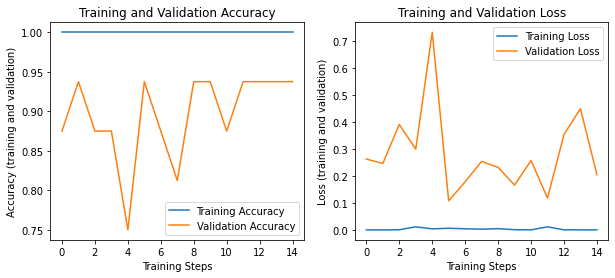

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

Résultats du graphique
Tester au hasard :
Choisissez cinq images au hasard dans l'ensemble de données de validation et faites la prédiction suivante :

1/1 [==============================] - 1s 1s/step
class: Benign, confidence: 0.839598


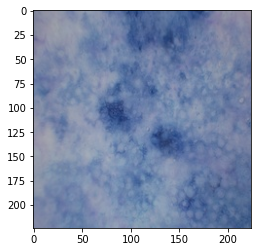

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 82ms/step
class: Benign, confidence: 0.999884


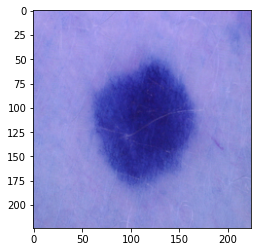

1/1 [==============================] - 0s 78ms/step
class: Benign, confidence: 0.979822


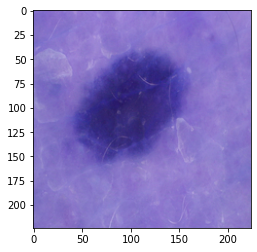

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 88ms/step
class: Malignant, confidence: 0.565261


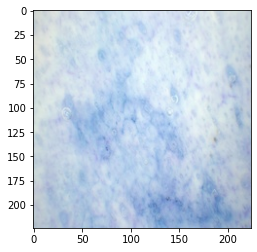

<Figure size 432x288 with 0 Axes>

In [ ]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    return {Labels[classx]: x[classx]}
images = random.sample(validation_generator.filenames, 4)

for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

Remarque : si vous ajustez quelques hyperparamètres, le modèle s'améliorera. Vous voudrez peut-être essayer un autre modèle pré-formé. Cela dépend entièrement de vous.

Matrice de confusion

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

1/1 [==============================] - 1s 1s/step
Classification Report
              precision    recall  f1-score   support

      benign       1.00      0.88      0.93         8
   malignant       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16

1/1 [==============================] - 1s 979ms/step - loss: 0.2169 - accuracy: 0.9375
[0.21687427163124084, 0.9375]


Confusion Matrix


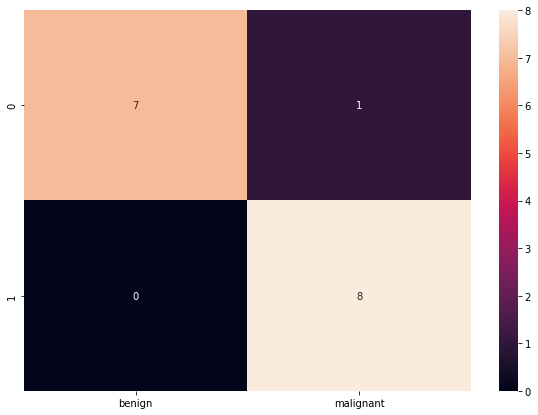

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

Exporter en tant que modèle enregistré et convertir en TFLite :

In [ ]:
import time
t = time.time()
export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)
export_path

'/tmp/saved_models/1676070667'

In [ ]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: malignant, file: malignant/18.jpg
1/1 [==============================] - 2s 2s/step
PREDICTED: class: Malignant, confidence: 0.963226


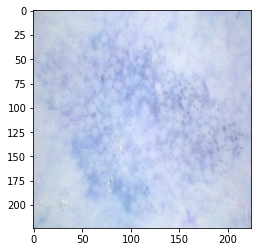

<Figure size 432x288 with 0 Axes>

SOURCE: class: malignant, file: malignant/16.jpg
1/1 [==============================] - 0s 137ms/step
PREDICTED: class: Benign, confidence: 0.840327


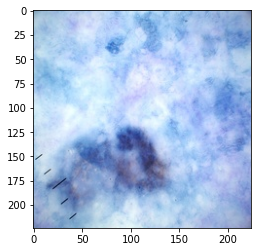

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"

# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)
# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

26098316